In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import RMSprop
import numpy as np
import random
import sys

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
filename = "/kaggle/input/the-jungle-booktxt/the_jungle_book.txt"
raw_text = open(filename, 'r', encoding='utf-8').read()

In [3]:
print(raw_text[500:600])

this eBook.

Title: The Jungle Book

Author: Rudyard Kipling

Illustrator: M. & E. Detmold

Release 


In [4]:
raw_text = raw_text.lower() # all the sentence to lower case
print(raw_text[500:600]) # after creating making the lower case

this ebook.

title: the jungle book

author: rudyard kipling

illustrator: m. & e. detmold

release 


In [5]:
#Remove numbers
raw_text = ''.join(c for c in raw_text if not c.isdigit())

In [6]:
#How many total characters do we have in our training text?
chars = sorted(list(set(raw_text))) #List of every character
chars

['\n',
 ' ',
 '!',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '?',
 '[',
 ']',
 '_',
 '`',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 'â',
 '—',
 '’',
 '“',
 '”',
 '•',
 '™',
 '\ufeff']

need to remove the special character

In [7]:
#Each unique character will be assigned an integer value. 
#Create a dictionary of characters mapped to integer values
char_to_int = dict((c, i) for i, c in enumerate(chars))
char_to_int

{'\n': 0,
 ' ': 1,
 '!': 2,
 '#': 3,
 '$': 4,
 '%': 5,
 '&': 6,
 "'": 7,
 '(': 8,
 ')': 9,
 '*': 10,
 ',': 11,
 '-': 12,
 '.': 13,
 '/': 14,
 ':': 15,
 ';': 16,
 '?': 17,
 '[': 18,
 ']': 19,
 '_': 20,
 '`': 21,
 'a': 22,
 'b': 23,
 'c': 24,
 'd': 25,
 'e': 26,
 'f': 27,
 'g': 28,
 'h': 29,
 'i': 30,
 'j': 31,
 'k': 32,
 'l': 33,
 'm': 34,
 'n': 35,
 'o': 36,
 'p': 37,
 'q': 38,
 'r': 39,
 's': 40,
 't': 41,
 'u': 42,
 'v': 43,
 'w': 44,
 'x': 45,
 'y': 46,
 'z': 47,
 'â': 48,
 '—': 49,
 '’': 50,
 '“': 51,
 '”': 52,
 '•': 53,
 '™': 54,
 '\ufeff': 55}

In [8]:
#Do the reverse so we can print our predictions in characters and not integers
int_to_char = dict((i, c) for i, c in enumerate(chars))
int_to_char

{0: '\n',
 1: ' ',
 2: '!',
 3: '#',
 4: '$',
 5: '%',
 6: '&',
 7: "'",
 8: '(',
 9: ')',
 10: '*',
 11: ',',
 12: '-',
 13: '.',
 14: '/',
 15: ':',
 16: ';',
 17: '?',
 18: '[',
 19: ']',
 20: '_',
 21: '`',
 22: 'a',
 23: 'b',
 24: 'c',
 25: 'd',
 26: 'e',
 27: 'f',
 28: 'g',
 29: 'h',
 30: 'i',
 31: 'j',
 32: 'k',
 33: 'l',
 34: 'm',
 35: 'n',
 36: 'o',
 37: 'p',
 38: 'q',
 39: 'r',
 40: 's',
 41: 't',
 42: 'u',
 43: 'v',
 44: 'w',
 45: 'x',
 46: 'y',
 47: 'z',
 48: 'â',
 49: '—',
 50: '’',
 51: '“',
 52: '”',
 53: '•',
 54: '™',
 55: '\ufeff'}

In [9]:
# summarize the data
n_chars = len(raw_text)
n_vocab = len(chars)
print("Total Characters in the text; corpus length: ", n_chars)
print("Total Vocab: ", n_vocab)


Total Characters in the text; corpus length:  291930
Total Vocab:  56


In [10]:

seq_length = 60  #Length of each input sequence
step = 10   #Instead of moving 1 letter at a time, try skipping a few. 
sentences = []    # X values (Sentences)
next_chars = []   # Y values. The character that follows the sentence defined as X

In [11]:
for i in range(0, n_chars - seq_length, step):  #step=1 means each sentence is offset just by a single letter
    sentences.append(raw_text[i: i + seq_length])  #Sequence in
    next_chars.append(raw_text[i + seq_length])  #Sequence out
n_patterns = len(sentences)    
print('Number of sequences:', n_patterns)

Number of sequences: 29187


# Vectorization

In [12]:
x = np.zeros((len(sentences), seq_length, n_vocab), dtype=np.bool)
y = np.zeros((len(sentences), n_vocab), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_to_int[char]] = 1
    y[i, char_to_int[next_chars[i]]] = 1
    

/tmp/ipykernel_28/2347007037.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.zeros((len(sentences), seq_length, n_vocab), dtype=np.bool)
/tmp/ipykernel_28/2347007037.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.zeros((len(sentences), n_vocab), dtype=np.bool)


In [13]:
print(x.shape)
print(y.shape)
# 60 is the sequence length and 56 is the number of words in
# to fill the sequence 

(29187, 60, 56)
(29187, 56)


In [14]:
print(y[0:5])

[[False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False  True False False False
  False False False False False False False False False False False False
  False False False False False False False False]
 [False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False  True False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False]
 [False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False  True False False False False False
  False False False False False False False False False False False False
  False Fa

# LSTM

In [15]:
model = Sequential()
model.add(LSTM(128, input_shape=(seq_length, n_vocab)))
model.add(Dense(n_vocab, activation='softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               94720     
                                                                 
 dense (Dense)               (None, 56)                7224      
                                                                 
Total params: 101,944
Trainable params: 101,944
Non-trainable params: 0
_________________________________________________________________


/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# Checkpoint

In [16]:
from keras.callbacks import ModelCheckpoint

filepath="saved_weights/saved_weights-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint]

In [27]:
history = model.fit(x, y,
          batch_size=128,
          epochs=100,   
          callbacks=callbacks_list)


Epoch 1/100
228/229 [============================>.] - ETA: 0s - loss: 0.6261
Epoch 1: loss improved from 0.63163 to 0.62647, saving model to saved_weights/saved_weights-01-0.6265.hdf5
229/229 [==============================] - 1s 6ms/step - loss: 0.6265
Epoch 2/100
229/229 [==============================] - ETA: 0s - loss: 0.6218
Epoch 2: loss improved from 0.62647 to 0.62181, saving model to saved_weights/saved_weights-02-0.6218.hdf5
229/229 [==============================] - 1s 6ms/step - loss: 0.6218
Epoch 3/100
223/229 [============================>.] - ETA: 0s - loss: 0.6199
Epoch 3: loss did not improve from 0.62181
229/229 [==============================] - 1s 6ms/step - loss: 0.6228
Epoch 4/100
227/229 [============================>.] - ETA: 0s - loss: 0.6098
Epoch 4: loss improved from 0.62181 to 0.60949, saving model to saved_weights/saved_weights-04-0.6095.hdf5
229/229 [==============================] - 1s 6ms/step - loss: 0.6095
Epoch 5/100
224/229 [=======================

In [28]:
model.save('my_saved_weights_jungle_book_50epochs.h5')

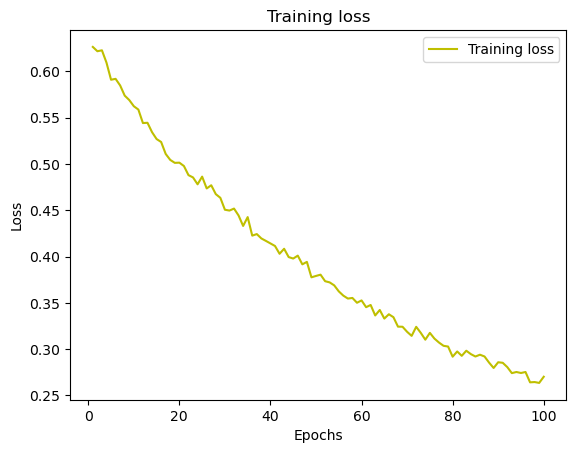

In [29]:
from matplotlib import pyplot as plt
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
def sample(preds):
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds)
    exp_preds= np.exp(preds)
    preds = exp_preds/ np.sum(exp_preds)
    probas = np.random.multinomial(i, preds , 1)
    return np.argmax(probas)

In [31]:
#Prediction
# load the network weights
filename = "my_saved_weights_jungle_book_50epochs.h5"
model.load_weights(filename)

In [32]:
#Pick a random sentence from the text as seed.
start_index = random.randint(0, n_chars - seq_length - 1)

In [33]:
#Initiate generated text and keep adding new predictions and print them out
generated = ''
sentence = raw_text[start_index: start_index + seq_length]
generated += sentence


In [34]:
print('----- Seed for our text prediction: "' + sentence + '"')
#sys.stdout.write(generated)


----- Seed for our text prediction: "of elephant’s foot tracks, a jungle
bear. bah! shame! go!”

"


In [35]:
for i in range(400):   # Number of characters including spaces
    x_pred = np.zeros((1, seq_length, n_vocab))
    for t, char in enumerate(sentence):
        x_pred[0, t, char_to_int[char]] = 1.

    preds = model.predict(x_pred, verbose=0)[0]
    next_index = sample(preds)
    next_char = int_to_char[next_index]

    generated += next_char
    sentence = sentence[1:] + next_char

    sys.stdout.write(next_char)
    sys.stdout.flush()
print()















mongoome, and he was mother’s parted on his shee poll belishs,
brother, they cubrong his deeppy--lowed his fightebe gut, whend he could get the rush of mish
spirke
brottherndad up
     brothe toomai look and seven the survea on a cird,” he had a good eanking and crosped his head of rad
acio, bounder the caw round the furs, tremone back an
in the holled the sapped on his hee was a star
